# 为什么需要图像抖动

在数字图像中，为了表示数字图像的细节，像素的颜色深度信息最少也是8位，即 $0  - 256$. 但是在实际中，我们有很多显示设备的颜色深度信息仅有4位，甚至1位，即黑白。这样当我们试图在这样的设备上显示一副有深度信息的图像时，如果不做特殊的处理，就会遇到很大的麻烦。

所以，图像抖动算法（Image Dithering）最早是在数字图像处理中为了解决颜色深度受限制的问题而提出的。当图像的颜色深度较低，即每个像素可以表示的颜色数量有限时，图像的颜色表现力会受到限制，这可能会导致严重的颜色带状现象（banding）和颜色失真。

图像抖动算法的核心思想是通过在图像中引入一些噪声，将颜色误差以某种方式分散到附近的像素，使得在视觉上能够模拟出更多的颜色。这种技术尤其在早期的计算机图形显示系统中被广泛使用，因为这些系统的颜色深度通常非常有限。例如，在黑白打印机或只有黑白显示能力的设备中，通过抖动算法可以产生不同灰度级别的效果。

# 图像抖动算法实现的基本思路 

图像抖动算法的基本思路是在减少颜色深度或者灰度等级时，尽可能地保留原始图像的视觉信息。这通常涉及到一种称为"误差扩散"的方法，该方法将每个像素值从其原始值量化到最近的可用颜色或灰度等级，并将造成的误差分散到周围的像素。

以下是图像抖动算法的基本步骤：

* 选择一个图像和一个颜色或灰度级别的集合：这个集合可能只有两个颜色（如黑白），也可能有多个颜色。

* 遍历图像的每个像素：对于图像中的每个像素，算法都会尝试找到最接近该像素颜色的颜色，然后将该像素颜色设置为该颜色。这个步骤通常称为"量化"。

* 计算误差：量化步骤会导致一些颜色信息的丢失。这种丢失的颜色信息被称为"误差"，可以通过将原始像素颜色和量化后的像素颜色相减来计算。

* 扩散误差：接下来，算法将这个误差分散到相邻的像素。这个步骤的目的是尽可能地减少量化步骤对图像视觉质量的影响。误差可以按照多种方式分散，具体取决于使用的抖动算法。

重复以上步骤：算法将重复以上步骤，直到遍历了图像中的所有像素。

通过这种方式，抖动算法能够在颜色或灰度级别受限的情况下，模拟出更多的颜色或灰度等级，从而提高图像的视觉质量。

![在这里插入图片描述](https://img-blog.csdnimg.cn/152451a7e4c541e4a9f7f52fbe79b380.png#pic_center)

比方说，上图所示的Firefox标识，最左侧的是具有8位深度信息的灰度图，但是中间和右侧的都是只有1位深度信息的黑白图。从视觉看似乎很相似，甚至细节上没有太多缺失。但是如果放大后看，就是下面这个效果了。

![在这里插入图片描述](https://img-blog.csdnimg.cn/a20dd442053545138693e1c5e56e493d.png#pic_center)

# 常见图像抖动算法实现

图像抖动的实现算法有很多，但是在这里我只实现了其中两种，现在就具体说明。

## Floyd-Steinberg 抖动算法

Floyd-Steinberg 抖动算法将误差分散到当前像素的右边和下面的像素。具体的误差扩散模式如下：

```bash
 X   7/16
3/16 5/16 1/16
```

在这个模式中，X 表示当前像素，数字表示误差扩散的比例。例如，当前像素的右边像素将接收 7/16 的误差，下面一行的左边、中间和右边的像素分别接收 3/16、5/16 和 1/16 的误差。

## Atkinson 抖动算法

Atkinson 抖动算法将误差分散到当前像素的右边和下面的像素，但它的误差扩散模式与 Floyd-Steinberg 不同：

```bash
 X  1/8 1/8
1/8 1/8
    1/8
```

在这个模式中，误差被均匀地分散到六个像素，每个像素接收 1/8 的误差。

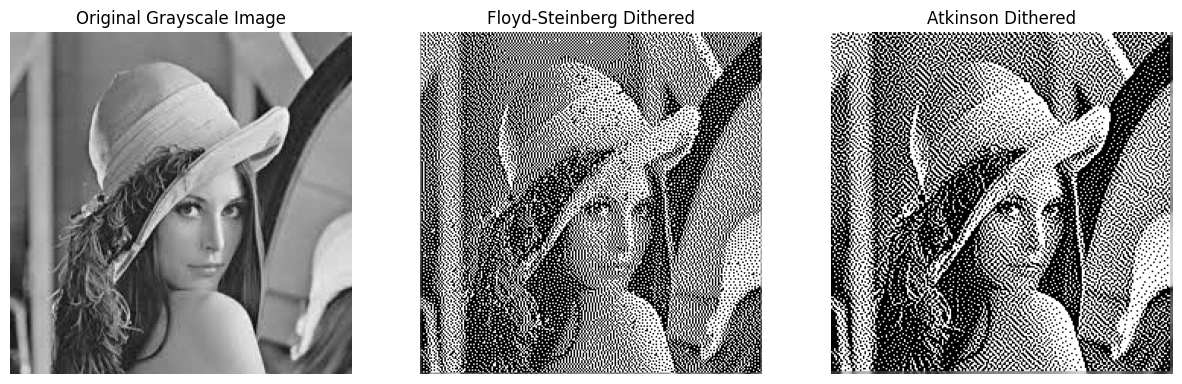

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


#################### Floyd-Steinberg Dithering ####################

def floyd_steinberg_dithering_kernel(image):
    for y in range(image.shape[0] - 1):
        for x in range(1, image.shape[1] - 1):
            old_pixel = image[y, x]
            new_pixel = np.round(old_pixel / 255) * 255
            image[y, x] = new_pixel
            error = old_pixel - new_pixel
            image[y, x + 1] += error * 7 / 16
            image[y + 1, x - 1] += error * 3 / 16
            image[y + 1, x] += error * 5 / 16
            image[y + 1, x + 1] += error * 1 / 16
    return image


#################### Atkinson Dithering ####################

def atkinson_dithering_kernel(image):
    error = np.zeros_like(image, dtype=np.float32)
    for y in range(image.shape[0] - 2):
        for x in range(image.shape[1] - 2):
            old_pixel = image[y, x] + error[y, x]
            new_pixel = np.round(old_pixel / 255) * 255
            image[y, x] = new_pixel
            diff = old_pixel - new_pixel
            error[y, x + 1] += diff * 1 / 8
            error[y, x + 2] += diff * 1 / 8
            error[y + 1, x - 1] += diff * 1 / 8
            error[y + 1, x] += diff * 1 / 8
            error[y + 1, x + 1] += diff * 1 / 8
            error[y + 2, x] += diff * 1 / 8
    return image


def display_images(original, fs_dithered, atk_dithered):
    """Display original and dithered images using matplotlib."""
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Grayscale Image")
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Floyd-Steinberg Dithered")
    plt.imshow(fs_dithered, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Atkinson Dithered")
    plt.imshow(atk_dithered, cmap='gray')
    plt.axis('off')

    plt.show()


def main():
    # Load an RGB image as grayscale
    gray_image = cv2.imread("/opt/images/lena.png", cv2.IMREAD_GRAYSCALE)

    # Apply Floyd-Steinberg dithering
    fs_dithered_image = floyd_steinberg_dithering_kernel(np.copy(gray_image))

    # Apply Atkinson dithering
    atk_dithered_image = atkinson_dithering_kernel(np.copy(gray_image.astype(np.float32))).astype(np.uint8)

    # Display images in Jupyter Notebook
    display_images(gray_image, fs_dithered_image, atk_dithered_image)


if __name__ == "__main__":
    main()
